## Ridge Regression Multi Variable ##

The following script contains two main parts; The first creates a clean and rescaled dataset with rents per hour left-joined on the available temperatures per hour for 2019. The second part creates a ridge model and visualize the regression/prediction.

In [157]:
# Import required libraries
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Import data from previous results and create DataFrame objects
Weather = pd.read_csv('weather_hourly_boston.csv', sep=',')
Rents = pd.read_csv('KPI_total_rents_per_hour.csv', sep=',')
df_rents = pd.DataFrame(Rents)
df_weather = pd.DataFrame(Weather)

# Clean the weather dataset and get data for 2019 only
df_weather = df_weather.dropna()
begin_2019 = pd.to_datetime('2019-01-01 00:00')
end_2019 = pd.to_datetime('2019-12-31 23:00')
times = pd.to_datetime(df_weather.date_time)
df_weather_2019 = df_weather.loc[(times.dt.year >= 2019) & (times.dt.year <= 2019)]
df_weather_2019 = df_weather_2019.reset_index()
df_weather_2019 = df_weather_2019.set_index('date_time')

# Create the combined dataset. Do a left-join on weather dataset timestamps.
df_weather_2019.index = df_weather_2019.index.rename('hour')
df_weather_and_rents = pd.merge(df_weather_2019,df_rents,on='hour',how='left')
df_weather_and_rents = df_weather_and_rents.drop_duplicates(subset=['hour'], keep='first')
df_weather_and_rents = df_weather_and_rents.dropna()
df_weather_and_rents = df_weather_and_rents.sort_values(by=['hour'])
df_weather_and_rents = df_weather_and_rents.drop('index', axis='columns')
df_weather_and_rents['avg_temp'] = (df_weather_and_rents['max_temp'] + df_weather_and_rents['min_temp'])/2
df_weather_and_rents = df_weather_and_rents.drop(['min_temp','max_temp'], axis='columns')

df_weather_and_rents['datetime'] = df_weather_and_rents['hour']
df_weather_and_rents.drop('hour', axis = 1)



#prepare the data
df = pd.DataFrame(df_weather_and_rents['datetime'])

times = pd.to_datetime(df.datetime)
dailyData = pd.DataFrame(times)
dailyData["hour"] = times.dt.hour
dailyData["weekday"] = times.dt.weekday
dailyData["month"] = times.dt.month
df_weather_and_rents['hour'] = dailyData['hour']
df_weather_and_rents['weekday'] = dailyData['weekday']
df_weather_and_rents['month'] = dailyData['month']


In [148]:
df_weather_and_rents

,hour,precip,rents_count,avg_temp,datetime,weekday,month
5,0,1.0,7.0,5.6,2019-01-01 00:00:00,1,1
0,1,1.0,24.0,3.9,2019-01-01 01:00:00,1,1
1,2,1.0,5.0,3.3,2019-01-01 02:00:00,1,1
2,3,1.0,3.0,2.8,2019-01-01 03:00:00,1,1
4,4,1.0,1.0,3.6,2019-01-01 04:00:00,1,1
...,...,...,...,...,...,...,...
8682,19,0.0,100.0,3.9,2019-12-31 19:00:00,1,12
8683,20,0.0,57.0,3.3,2019-12-31 20:00:00,1,12
8684,21,1.0,48.0,3.3,2019-12-31 21:00:00,1,12
8685,22,0.0,40.0,3.3,2019-12-31 22:00:00,1,12


In [149]:
#Change categorical data type for memory reduction
categorical_features = ['hour', 'precip', 'avg_temp', 'datetime']

for feature in categorical_features:
    df_weather_and_rents[feature] = df_weather_and_rents[feature].astype("category")

#Separate train and test data. 
train, test = train_test_split(df_weather_and_rents, test_size = 0.7, random_state = 42)
train.info()

#Assign train target value(y)
y = train['rents_count']

#Drop useless features
drop_features = ['rents_count', 'datetime']

X_train = train.drop(drop_features, axis=1)
X_test = test.drop(drop_features, axis=1)
X_train.info()




<class 'pandas.core.frame.DataFrame'>
Int64Index: 2447 entries, 8049 to 7744
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   hour         2447 non-null   category
 1   precip       2447 non-null   category
 2   rents_count  2447 non-null   float64 
 3   avg_temp     2447 non-null   category
 4   datetime     2447 non-null   category
 5   weekday      2447 non-null   int64   
 6   month        2447 non-null   int64   
dtypes: category(4), float64(1), int64(2)
memory usage: 419.0 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2447 entries, 8049 to 7744
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   hour      2447 non-null   category
 1   precip    2447 non-null   category
 2   avg_temp  2447 non-null   category
 3   weekday   2447 non-null   int64   
 4   month     2447 non-null   int64   
dtypes: category(3), int64(2)
memory usage: 73.3 K

In [150]:
#Evaluation score(RMSLE) function

def rmsle(y_true, y_pred, convertExp=True):
    # Apply exponential transformation function
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # Convert missing value to zero after log transformation
    log_true = np.nan_to_num(np.array([np.log(y+1) for y in y_true]))
    log_pred = np.nan_to_num(np.array([np.log(y+1) for y in y_pred]))
    
    # Compute RMSLE
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output


In [154]:
# Step 1: Create Model
ridge_model = Ridge()

# Step 2-1 : Create GridSearchCV Object
# Hyper-parameter List
ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
# Evaluate Function for Cross-Validation (RMSLE score)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False) 
# Create GridSearchCV Object (with Ridge)
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,
                                      param_grid=ridge_params,
                                      scoring=rmsle_scorer,
                                      cv=5)

# Step 2-2 : Perform Grid Search
log_y = np.log1p(y) # Log Transformation of Target Value y
gridsearch_ridge_model.fit(X_train, log_y) # Train (Grid Search)

print('Best Parameter:', gridsearch_ridge_model.best_params_)

# Step 3 : Predict
preds = gridsearch_ridge_model.best_estimator_.predict(X_train)

# Step 4 : Evaluate
print('Ridge Regression RMSLE:', rmsle(log_y, preds, True))
np.exp(preds)

Best Parameter: {'alpha': 10, 'max_iter': 3000}
Ridge Regression RMSLE: 1.1790809597978857


array([ 34.70351217, 300.01528571, 403.53918752, ...,  52.23438035,
        42.26224516,  71.57439331])

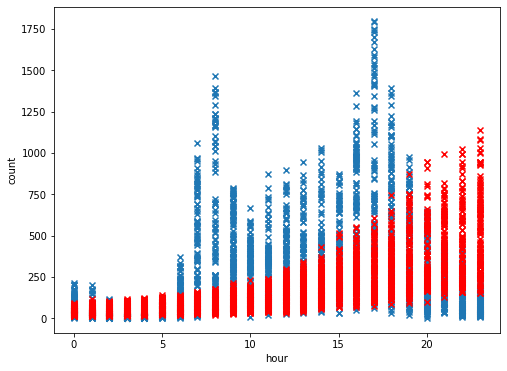

In [155]:
plt.figure(figsize = (8,6))
plt.scatter(X_train['hour'], train['rents_count'], marker="x")
plt.scatter(X_train['hour'], np.exp(preds), color = 'red', marker = 'x')
plt.xlabel("hour")
plt.ylabel("count")
plt.show()